# Capstone Project - The Battle of Neighborhoods (Week 2)

## Contents
* [Introduction: Business Problem](#intro)
* [Data](#data)
  * [Statistical Data on Neighbourhoods](#stats)
  * [Foursquare API data - Venue Details](#foursquare)
* [Data Exploration / Methodology](#methodology)
* [Analysis](#analysis)

**Note**: The results, discussion and conclusion sections are included in the report under the same github section

## Introduction / Business Problem <a name="intro"></a>

Finding the right small business location is one of the primary steps in preparing to set up a new business. It is not always an easy task. This project aims to help current and future business owners in the process of selecting business locations. By using data from a location based social network services like Foursquare as well as neighbourhood area statistics it should be possible to recommend possible business locations.

As the types of small businesses are manifold, this project will restrict the definition to those businesses that fall under the categories of shops, restaurants, cafes and bars. These types of businesses depend on foot traffic, easy access and good visibility.

### There are several of factors that can influence choosing a location:

* Location of similar businesses
 * Businesses are usually located where they are for a good reason,
 * Customers already in the area are more likely to be looking for a similar business
* Consumer statistics for similar business
 * Average number of customer visits. 
 * Popularity of a business
* Distance between consumers and business
 * The further the consumer is located from the business the less likely he or she is to visit.
 * Consumer location doesn't necesarily mean domestic location but could also mean job location.
* Location close to transportation hubs, parking facilities, entertainment centres like theatres, cinemas or public parks
 * Locations where there is a large amount of foot traffic: concentration of possible customers
* Population density of the surrounding area
 * More people close by: more possible customers
 * There are statistics available on population by neighbourhood or postal code area. 
* Average Income 
 * Higher average income: possible customers with more money to spend
 * There are statistics available on average income by neighbourhood. 

  **This project will attempt to combine the above factors to build a clustering and/or recommendation model<br>
  for the best areas for locating certain businesses. The recommendation(s) given by the model should help<br>
  the (future) business owner to make a more informed decision**

**Note**: only further analysis in the next stage after gathering the data will prove which machine learning method is better suited to use

In [11]:
# import the necessary libraries
import os
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import geopandas as gpd # libary for geo-spatial data processing and analysis
# import the Point object
from shapely.geometry import Point
import json # library to handle JSON files
import requests # library to handle requests
import pickle # library to save serialized
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# no warnings
import warnings
warnings.filterwarnings('ignore')
# we need some modules from scikit-learn
from sklearn import preprocessing
# import k-means for the clustering stage
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show plots inline
%matplotlib inline

## Data Section <a name="data"/>

## Statistics Data on Neighbourhoods <a name="stats"/>

I have chosen to look at the neighbourhoods in the former city of Toronto for this study. This is based on the fact that the city has a substantially large population with readily available statistics.

### 1. Neighbourhoods with central and boundary geo-coordinates with the following columns:

 * **CDN_Number**: Area code for the neighbourhood, 3 digits
 * **Neighbourhood**: Name of the neighbourhood
 * **geometry**: collection of geo-coordinates designating the boundary of the neigbourhood
 * **Latitude**: the latitudinal coordinate of the center of the area (centroid)
 * **Longitude**: the longitudinal coordinate of the center of the area (centroid)
 
 **Neighbourhood**: according to the website of the city of Toronto, the definition of a neighbourhood<br>
 is an area that respects existing boundaries such as service boundaries of community agencies, <br>
 natural boundaries (rivers), and man-made boundaries (streets, highways, etc.)<br>
 They are small enough for service organizations to combine them to fit within their service area.<br>
 They represent municipal planning areas as well as areas for public service like public health.<br>
 A neighbourhood has a population roughly between 7,000 and 12,00 people.

### Example data:

In [12]:
# convert the neighbourhood's boundaries shapefile to a geopandas dataframe
df_toronto_nbh_geo = gpd.read_file('./data/NEIGHBORHOODS_WGS84.shp')
# rename the columns
df_toronto_nbh_geo.rename(columns={'AREA_S_CD':'CDN_Number', 'AREA_NAME':'Neighbourhood'}, inplace=True)
# remove the brackets in the neighbourhod name column
fix_neighbourhood = lambda x: x.split('(')[0]
df_toronto_nbh_geo['Neighbourhood'] = df_toronto_nbh_geo['Neighbourhood'].apply(fix_neighbourhood)
# calculate the centers of each area 
df_toronto_nbh_geo['Latitude'] = df_toronto_nbh_geo['geometry'].centroid.y
df_toronto_nbh_geo['Longitude'] = df_toronto_nbh_geo['geometry'].centroid.x
# display the dimensions and first five rows
print('Dimensions: ', df_toronto_nbh_geo.shape)
df_toronto_nbh_geo.head()

Dimensions:  (140, 5)


,CDN_Number,Neighbourhood,geometry,Latitude,Longitude
0,097,Yonge-St.Clair,"POLYGON ((-79.39119482700001 43.681081124, -79...",43.687859,-79.397871
1,027,York University Heights,"POLYGON ((-79.505287916 43.759873494, -79.5048...",43.765738,-79.488883
2,038,Lansing-Westgate,"POLYGON ((-79.439984311 43.761557655, -79.4400...",43.754272,-79.424747
3,031,Yorkdale-Glen Park,"POLYGON ((-79.439687326 43.705609818, -79.4401...",43.714672,-79.457108
4,016,Stonegate-Queensway,"POLYGON ((-79.49262119700001 43.64743635, -79....",43.635518,-79.501128


**Note**:In the case of the neighbourhoods geospatial data no data cleansing is necessary, other than removing<br>
removing the CDN number from the description. I have renamed the columns to be consistent.<br>
The centeral geo-coordinates for each neighbourhood have also been calculated using a geopandas geometry<br>
attribute called centroid.

### 2. Wikipedia table containing neighbourhoods by former city / borough

  This table is used to filter the neighbourhoods by the former city area of Toronto: 
  https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto
  * **CDN_Number**: Area code for the neighbourhood, 3 digits
  * **City-designated-area**: Name of the neighbourhood
  * **Borough**: Former city or borough

In [13]:
# read the table in the Wikipedia page
df_toronto_nbh_bor = pd.read_html('https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto')[0]
# remove columns not needed and rename the remaining
df_toronto_nbh_bor.drop(columns=['Map','Neighbourhoods covered'],inplace=True)
df_toronto_nbh_bor.rename(columns={'CDN number':'CDN_Number','Former city/borough':'Borough'}, inplace=True)
# format the CDN number column so that it matches that of the previous dataframe
zero_fill = lambda x: "{:03d}".format(x)
df_toronto_nbh_bor['CDN_Number'] = df_toronto_nbh_bor['CDN_Number'].apply(zero_fill)
# display the dimensions and first five rows
print('Dimensions: ', df_toronto_nbh_bor.shape)
df_toronto_nbh_bor.head()

Dimensions:  (140, 3)


,CDN_Number,City-designated area,Borough
0,129,Agincourt North,Scarborough
1,128,Agincourt South-Malvern West,Scarborough
2,020,Alderwood,Etobicoke
3,095,Annex,Old City of Toronto
4,042,Banbury-Don Mills,North York


  **Note**: In the case of the wikipedia list of neighbourhoods in Toronto, there are now missing values.<br>
  To be consistant, I have reformated the CDN number to a zero-fill 3 digit number.<br>
  Just to make sure I compared the CDN numbers and neighbourhood names to the neighbourhood<br>
  geospatial file and there were no differences. The number of rows (read neighbourhoods is the same)

### 3. Toronto Population Statistics by Neighbourhood

  Neighbourhood population , area and household income from 2014. 
  
  This can be retrieved from the city of Toronto neighbourhood wellbeing app
  https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/wellbeing-toronto/
  
  The file contains the following columns:
  * **Neighbourhood**: Name of the neighbourhood
  * **CDN_Number**: Three digit neighbourhood code
  * **TotalPopulation**: Total population for the neighbourhood based on 2014 data
  * **TotalArea**: Area of the neighbourhood in square kilometers
  * **After_TaxHouseholdIncome**: Average household income after tax in Canadian dollars
  * **PopulationDensity**: Density of the population by square kilometers
  
  This excel file will be loaded into a pandas dataframe 

### Example data:

In [14]:
# read the 2014 statistics excel file
df_toronto_nbh_sta = pd.read_excel('./data/wellbeing_toronto_2014.xlsx')
# remove unwanted columns
df_toronto_nbh_sta.drop(columns=['Combined Indicators','Average Family Income'],inplace=True)
# rename the neighbourhood id column to CDN_Number to match other dataframe
rename_columns = {'Neighbourhood Id':'CDN_Number',
                  'Total Population':'TotalPopulation',
                  'Total Area':'TotalArea',
                  'After-Tax Household Income':'AfterTaxHouseholdIncome'}
df_toronto_nbh_sta.rename(columns=rename_columns,inplace=True)
# reformat the CDN_Number column to match the other similar dataframe columns
zero_fill = lambda x: "{:03d}".format(x)
df_toronto_nbh_sta['CDN_Number'] = df_toronto_nbh_sta['CDN_Number'].apply(zero_fill)
# add column with population density
df_toronto_nbh_sta['PopulationDensity'] = round(df_toronto_nbh_sta['TotalPopulation']/df_toronto_nbh_sta['TotalArea'],0)
df_toronto_nbh_sta.head()

,Neighbourhood,CDN_Number,TotalPopulation,TotalArea,AfterTaxHouseholdIncome,PopulationDensity
0,West Humber-Clairville,001,33312,30.09,59703,1107.0
1,Mount Olive-Silverstone-Jamestown,002,32954,4.60,46986,7164.0
2,Thistletown-Beaumond Heights,003,10360,3.40,57522,3047.0
3,Rexdale-Kipling,004,10529,2.50,51194,4212.0
4,Elms-Old Rexdale,005,9456,2.90,49425,3261.0


  **Note**: There were no empty values in this table and the number of rows compared with the previous<br>
  neighbourhood files. To be consistent, I have reformatted the CDN number to a zero-fill 3 digit number.<br>
  Just to make sure I compared the CDN numbers and neighbourhood names to the neighbourhood <br>
  geospatial file and there were no differences. A population density column was calculated by dividing<br>
  the total population by the total area of the neighbourhood.

### 4. Combined table with neighbourhood as key

  The three above mentioned tables will be loaded and joined based on FSA code to form a dataframe containing 
  the following columns:
  
 * **CDN_Number**: Three digits designating a neighbourhood (data 1.)
 * **Neighbourhood**: Name of the neighbourhood (data 1.)
 * **Latitude**: the latitudinal coordinate of the center of the area (data 1.)
 * **Longitude**: the longitudinal coordinate of the center of the area (data 1.)
 * **geometry**: a list of latitude - longitude coordinates forming the boundaries of the neighbourhood (data 1.)
 * **TotalPopulation**: the total population of the neighbourhood (data 3.)
 * **TotalArea**: the total area in square kilometers (data 3.)
 * **AfterTaxHouseholdIncome**: average household income after tax for the neighbourhod (data 3.)
 * **PopulationDensity**: the population density of the area in persons by square km (TotalPopulation/TotalArea)

  This dataframe named **df_toronto_ven** will form the features for a neighbourhod and used for the machine learning algorithm

### Example data:

  Only the neighbourhoods in the former city of Toronto have been retained<br>
  After removing several (duplicate) columns, the following columns are available as shown below:

In [15]:
# Now join the three dataframes
df_toronto_nbh_tmp = pd.merge(left=df_toronto_nbh_geo,right=df_toronto_nbh_bor,on='CDN_Number')
df_toronto_nbh_tmp = df_toronto_nbh_tmp[df_toronto_nbh_tmp['Borough'] == 'Old City of Toronto']
df_toronto_nbh_tmp.drop(columns=['City-designated area','Borough'],inplace=True)
#df_toronto_nbh.rename(columns={'NeighbourhoodGeo':'Neighbourhood'},inplace=True)
df_toronto_nbh = pd.merge(left=df_toronto_nbh_tmp,right=df_toronto_nbh_sta,on='CDN_Number')
df_toronto_nbh.drop(columns=['Neighbourhood_y'],inplace=True)
df_toronto_nbh.rename(columns={'Neighbourhood_x':'Neighbourhood'},inplace=True)
df_toronto_nbh.sort_values('Neighbourhood',inplace=True)
df_toronto_nbh.reset_index(drop=True,inplace=True)
print('Dimensions: ',df_toronto_nbh.shape)
df_toronto_nbh.head()

Dimensions:  (44, 9)


,CDN_Number,Neighbourhood,geometry,Latitude,Longitude,TotalPopulation,TotalArea,AfterTaxHouseholdIncome,PopulationDensity
0,095,Annex,"POLYGON ((-79.39414141500001 43.668720261, -79...",43.671585,-79.404000,30526,2.8,49912,10902.0
1,076,Bay Street Corridor,"POLYGON ((-79.38751633 43.650672917, -79.38662...",43.657512,-79.385722,25797,1.8,44614,14332.0
2,069,Blake-Jones,"POLYGON ((-79.34082169200001 43.669213123, -79...",43.676173,-79.337394,7727,0.9,51381,8586.0
3,071,Cabbagetown-South St.James Town,"POLYGON ((-79.376716938 43.662418858, -79.3772...",43.667648,-79.366107,11669,1.4,50873,8335.0
4,096,Casa Loma,"POLYGON ((-79.414693177 43.673910413, -79.4148...",43.681852,-79.408007,10968,1.9,65574,5773.0


### Display the neighbourhoods on a map of Toronto by population density

  Each neighbourhood is shown with a boundary and a color varying from yellow to red, depending on the population<br>   density by square kilometer. This is a preliminary exploration into the data we have gathered.

In [16]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
map_toronto = folium.Map(location=[43.673963, -79.387207], zoom_start=12);
toronto_geojson = "./data/toronto_neighbourhoods.json"
map_toronto.choropleth(geo_data=toronto_geojson,
    data = df_toronto_nbh,
    popup=df_toronto_nbh['Neighbourhood'],
    columns=['Neighbourhood','PopulationDensity'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Population Density by Neighbourhood')   
# add markers to map
for lat, lng, cdn_number, neighborhood in zip(df_toronto_nbh['Latitude'], df_toronto_nbh['Longitude'], df_toronto_nbh['CDN_Number'], df_toronto_nbh['Neighbourhood']):
    label = '{} - {}'.format(neighborhood, cdn_number)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
map_toronto.save('toronto_map.html')

<img src='./toronto_map.jpeg'/>

## Foursquare API data - Venue Details <a name="foursquare" />

The Foursquare API will be used to collect venue data by FSA area. 
This data can then be combined with the FSA statistical data 
to be used by the chosen machine learning algorithm to provide insight in business location

In [17]:
# Set up Foursqaure API credentials
CLIENT_ID = '<client id here>' # your Foursquare ID
CLIENT_SECRET = '<client credentials here>' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### 5. Foursquare Venue Categories:
 
  Each venue on Foursqaure has been assigned to a category.
  This is is the lowest level category that is used by Foursqaure.
  
  Foursqaure usually has two levels of categories, the top level like Food, Arts & Entertainment etc.<br>
  Under each category there are several sub-categories.<br>
  For example Food has a long list of sub-categories including different restaurant types, cafes etc.
  
  There is a special entry point in the Foursqaure API to retrieve all categories and sub-categories.<br>
  This data will be stored in a table with the following fields:
  
  * **Category**: top level Foursquare venue catagory
  * **Subcategory**: lower level venue category
  
  The top level category will be used to categorize venues on a top level as well

In [18]:
# build the request to retrieve the Foursquare venue catagories
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
   CLIENT_ID, 
   CLIENT_SECRET, 
   VERSION
) 
# initialize variables
dict_cats = {}
list_cats = []
list_subcats = []
# check if the categories csv file already exists, if so then use it
# instead of calling the API
if os.path.exists('data/foursquare_categories.csv'):
    df_cats=pd.read_csv('data/foursquare_categories.csv',index_col=0)
else:
    # request the data from the API
    results = requests.get(url).json()
    # normalize the Json to a dataframe
    df_cats = json_normalize(results['response']['categories'])
    # get each category and sub-category from the categories column
    for idx,row in df_cats.iterrows():
        cats = row['categories']
        for v in cats:
            list_cats.append(row['name'])
            list_subcats.append(v['name'])
    dict_cats['Category'] = list_cats
    dict_cats['Subcategory'] = list_subcats
    # rebuild the dataframe from a dictionary
    df_cats = pd.DataFrame.from_dict(dict_cats)
    # save to csv for later use
    df_cats.to_csv('data/foursquare_categories.csv')
    
df_cats.head()

,Category,Subcategory
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


### 6. Foursquare Venues by Neighbourhood

  Use the Foursquare Venue Explore API endpoint to gather basic data on venues<br>
  with a certain radius based on the central coordinates for the area. 
  
  The data retrieed in JSON format will be stored in a dataframe with the following columns:
  
  * **CDN_Number**: Three digit neighbourhood code
  * **Neighbourhood**: Name of the neighbourhood the venue is located in
  * **Name**: Name of the venue
  * **Latitude**: Latitude coordinate of the venue
  * **Longitude**: Longitude coordinate of the venue
  * **Subcategory**: Lower level category name for the venue
  * **Category**: Highest level category , this will be added later

  **Note**: the venue category will be added to the dataframe using the Foursquare's categories dataframe (5)<br>
  **Note**: the venue CDN number and neighbourhood will be checked against the neighbourhoods boundaries

### Get the venues by neighbourhood using the Foursquare API explore endpoint

In [19]:
def get_nearby_venues(cdns, neighbourhoods, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for cdn, neighbourhood, lat, lng in zip(cdns, neighbourhoods, latitudes, longitudes):
        print(cdn,'-',neighbourhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venues = requests.get(url).json()["response"]['groups'][0]['items']
        # add a row for each venue
        for v in venues:
            vnam = v['venue']['name']             # venue name
            vlat = v['venue']['location']['lat']  # venue latitude
            vlng = v['venue']['location']['lng']  # venue longitude
            vcat = v['venue']['categories'][0]['name'] # venue subcategory
            venues_list.append([cdn,neighbourhood,vnam,vlat,vlng,vcat])            

    return(venues_list)

### Process retrieving venues by neighbourhood

  Loop through the neighbourhood dataframe to get the venues within a certain radius<br>
  of the center coordinates of each neighbourhood. Due to the fact that using a radius might<br>
  cause the API to get venues just outside of the current neighbourhood. All the venues found<br>
  will be verified and if necessary set to the correct neighbourhood

In [21]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius in meters
# call the API explore endpoint for each neighbourhood
venues_list = get_nearby_venues(cdns=df_toronto_nbh['CDN_Number'],
                                neighbourhoods=df_toronto_nbh['Neighbourhood'],
                                latitudes=df_toronto_nbh['Latitude'],
                                longitudes=df_toronto_nbh['Longitude']
                               )

095 - Annex 
076 - Bay Street Corridor 
069 - Blake-Jones 
071 - Cabbagetown-South St.James Town 
096 - Casa Loma 
075 - Church-Yonge Corridor 
092 - Corso Italia-Davenport 
066 - Danforth 
093 - Dovercourt-Wallace Emerson-Junction 
083 - Dufferin Grove 
062 - East End-Danforth 
102 - Forest Hill North 
101 - Forest Hill South 
065 - Greenwood-Coxwell 
088 - High Park North 
087 - High Park-Swansea 
090 - Junction Area 
078 - Kensington-Chinatown 
105 - Lawrence Park North 
103 - Lawrence Park South 
084 - Little Portugal 
073 - Moss Park 
099 - Mount Pleasant East 
104 - Mount Pleasant West 
082 - Niagara 
068 - North Riverdale 
074 - North St.James Town 
080 - Palmerston-Little Italy 
067 - Playter Estates-Danforth 
072 - Regent Park 
086 - Roncesvalles 
098 - Rosedale-Moore Park 
089 - Runnymede-Bloor West Village 
085 - South Parkdale 
070 - South Riverdale 
063 - The Beaches 
081 - Trinity-Bellwoods 
079 - University 
077 - Waterfront Communities-The Island 
091 - Weston-Pellam Pa

### Build the venues dataframe from the venues list and rename the columns

In [22]:
# build the dataframe from the venues list
df_toronto_ven = pd.DataFrame.from_records(venues_list)
# rename the columns
df_toronto_ven.columns = ['CDN_Number',
              'Neighbourhood', 
              'Venue', 
              'Latitude', 
              'Longitude', 
              'SubCategory']
# display the first 5 rows
print('Dimensions: ', df_toronto_ven.shape)
df_toronto_ven.head()

Dimensions:  (3411, 6)


,CDN_Number,Neighbourhood,Venue,Latitude,Longitude,SubCategory
0,095,Annex,Rose & Sons,43.675668,-79.403617,American Restaurant
1,095,Annex,Ezra's Pound,43.675153,-79.405858,Café
2,095,Annex,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
3,095,Annex,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant
4,095,Annex,Playa Cabana,43.676112,-79.401279,Mexican Restaurant


### Add the category column based on a dictionary lookup using the Foursquare categories dataframe

In [23]:
dict_cats = dict(zip(df_cats['Subcategory'],df_cats['Category']))
df_toronto_ven['Category'] = df_toronto_ven['SubCategory'].map(dict_cats)
df_toronto_ven.head()

,CDN_Number,Neighbourhood,Venue,Latitude,Longitude,SubCategory,Category
0,095,Annex,Rose & Sons,43.675668,-79.403617,American Restaurant,Food
1,095,Annex,Ezra's Pound,43.675153,-79.405858,Café,Food
2,095,Annex,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant,Food
3,095,Annex,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant,Food
4,095,Annex,Playa Cabana,43.676112,-79.401279,Mexican Restaurant,Food


### Check for the correct neighbourhood to each venue and correct if necessary

  The geopandas dataframe has a method to check if a geo-coordinate is with in the boundaries<br>
  of an area, in this case neighbourhood boundaries. The df_toronto_nbh dataframe has a column<br>
  with these boundaries and can be used to verify the venues geo-location.

In [24]:
# loop at all the venues
drop_index_list = []
corrected = 0
for i,ven in df_toronto_ven.iterrows():
    # create a Point based on the venues latitude and longitude coordinates
    pnt = Point(ven['Longitude'],ven['Latitude'])
    # get the venues neighbourhood number
    vcd = ven['CDN_Number']
    # loop at the neighbourhood dataframe
    found = False
    for j, nbh in df_toronto_nbh.iterrows():
        # check if the venues coordinates are within the neighbourhood's boundaries
        isin = pnt.within(nbh['geometry'])
        # the venue is in the current neighbourhood
        if isin:
            found = True
            if vcd != nbh['CDN_Number']:
                # print('Changed')
                corrected = corrected + 1
                df_toronto_ven.at[1,'CDN_Number'] = nbh['CDN_Number']  
                df_toronto_ven.at[1,'Neighbourhood'] = nbh['Neighbourhood']  
            break
    if found == False:
        drop_index_list.append(i)

### Report the corrections here and drop any venues that are out of bounds ...

In [25]:
# log the updates and drop rows that are not within any boundaries
print(df_toronto_ven.shape[0], 'venues checked')
# how many venues have had their neighbourhood reassigned
if corrected:
    print(corrected,' venues corrected')
if len(drop_index_list) > 0:
    # drop any rows contained in the drop_index_list => not found
    df_toronto_ven.drop(df_toronto_ven.index[drop_index_list],inplace=True)
    print('Venues removed: ', len(drop_index_list))
    df_toronto_ven.reset_index(drop=True,inplace=True)
# show what is left ...
print(df_toronto_ven.shape[0], 'venues remaining')

3411 venues checked
1491  venues corrected
Venues removed:  71
3340 venues remaining


### Display venues dataframe after assigning the correct neighbourhood
**Note**: As reported almost half of neighbourhood of all venues has been corrected. This is due to the fact<br>
that the Foursquare API endpoint "explore" only accepts a radius from a central point, which can lead to a venue<br>
being outside of the neighbourhood. 76 venues where entirely outside of the neighbourhoods and have been removed

In [26]:
df_toronto_ven.head()

,CDN_Number,Neighbourhood,Venue,Latitude,Longitude,SubCategory,Category
0,095,Annex,Rose & Sons,43.675668,-79.403617,American Restaurant,Food
1,096,Casa Loma,Ezra's Pound,43.675153,-79.405858,Café,Food
2,095,Annex,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant,Food
3,095,Annex,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant,Food
4,095,Annex,Playa Cabana,43.676112,-79.401279,Mexican Restaurant,Food


### Missing categories

One thing I noticed is that not all the venue subcategories were found according to the Foursquare<br>
categories - subcategories list. Therefore this needs to be corrected as well. Here is where the fun begins<br>
as quite a lot of code is necessary to fix this<br>

In [27]:
# fix the Category column based on certain key words in the subcategory
def fix_category(row):
    #print(pd.isna(row['Category']))
    if pd.isna(row['Category']):
        if 'restaurant' in str(row['SubCategory']).lower():
            return 'Food'
        elif 'food' in str(row['SubCategory']).lower():
            return 'Food'
        elif 'place' in str(row['SubCategory']).lower():
            return 'Food'
        elif 'churrascaria' in str(row['SubCategory']).lower():
            return 'Food'
        elif 'noodle' in str(row['SubCategory']).lower():
            return 'Food'
        elif str(row['SubCategory']) == 'Ice Cream Shop':
            return 'Food'
        elif 'store' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'shop' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'studio' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'gym' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'market' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'butcher' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'boutique' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'grocery' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'dojo' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'chiropractor' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'tech startup' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'coworking space' in str(row['SubCategory']).lower():
            return 'Shop & Service'
        elif 'bar' in str(row['SubCategory']).lower():
            return 'Nightlife Spot'
        elif 'pub' in str(row['SubCategory']).lower():
            return 'Nightlife Spot'
        elif 'club' in str(row['SubCategory']).lower():
            return 'Nightlife Spot'
        elif 'speakeasy' in str(row['SubCategory']).lower():
            return 'Nightlife Spot'
        elif 'theater' in str(row['SubCategory']).lower():
            return 'Arts & Entertainment'
        elif 'museum' in str(row['SubCategory']).lower():
            return 'Arts & Entertainment'
        elif 'bus' in str(row['SubCategory']).lower():
            return 'Travel & Transport'
        elif 'hostel' in str(row['SubCategory']).lower():
            return 'Travel & Transport'
        elif 'platform' in str(row['SubCategory']).lower():
            return 'Travel & Transport'
        elif 'school' in str(row['SubCategory']).lower():
            return 'Professional & Other Places'
        elif 'church' in str(row['SubCategory']).lower():
            return 'Professional & Other Places'
        elif 'field' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'court' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'track' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'rink' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'stadium' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'monument / landmark' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'arena' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'curling' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        elif 'outdoors & recreation' in str(row['SubCategory']).lower():
            return 'Outdoors & Recreation'
        else:
            return row['Category']
    else:
        return row['Category']


In [28]:
# fix the venue catagories by first creating a new column and then replacing the old one
df_toronto_ven['New Cat'] = df_toronto_ven.apply(lambda x: fix_category(x),axis=1)
# remove any rows where the subcategory is Neighborhood
df_toronto_ven = df_toronto_ven.query('SubCategory != "Neighborhood"')
# save to csv to check in excel just in case 
df_toronto_ven.to_csv('df_toronto_ven_after.csv')
# do we have any rows left without a category?
df_toronto_ven[df_toronto_ven['New Cat'].isnull()]

,CDN_Number,Neighbourhood,Venue,Latitude,Longitude,SubCategory,Category,New Cat


### Finally all the venues have been assigned now

One last step to replace the Category column with the "fixed" categories in column "New Cat"

In [29]:
# repair the Category column with the "New Cat" column and then drop "New Cat"
df_toronto_ven['Category'] = df_toronto_ven['New Cat']
df_toronto_ven.drop(columns=['New Cat'],inplace=True)
df_toronto_ven.sort_values(by=['Neighbourhood','Category','SubCategory'],inplace=True)
df_toronto_ven.reset_index(drop=True,inplace=True)
# final look
df_toronto_ven.head()

,CDN_Number,Neighbourhood,Venue,Latitude,Longitude,SubCategory,Category
0,095,Annex,Koerner Hall,43.667983,-79.395962,Concert Hall,Arts & Entertainment
1,095,Annex,Baldwin Steps,43.677707,-79.408209,Historic Site,Arts & Entertainment
2,095,Annex,Toronto Archives,43.676447,-79.407509,History Museum,Arts & Entertainment
3,095,Annex,The Bloor Hot Docs Cinema,43.665499,-79.410313,Indie Movie Theater,Arts & Entertainment
4,095,Annex,Royal Ontario Museum,43.668367,-79.394813,Museum,Arts & Entertainment


# Data exploration / Methodology <a name="methodology"/>

### Analysis of the data gathered

  To get a general idea, let's see how many venue categories we have found by neighbourhood

In [30]:
nhb_count = len(df_toronto_ven['Neighbourhood'].unique())
sub_count = len(df_toronto_ven['SubCategory'].unique())
cat_count = len(df_toronto_ven['Category'].unique())
ven_count = df_toronto_ven.shape[0]
print('{} top level categories with {} unique venue categories found across {} neighbourhoods\n{} venues in total'.format(
    cat_count,sub_count,nhb_count,ven_count))

8 top level categories with 281 unique venue categories found across 44 neighbourhoods
3331 venues in total


### Visualize the average household income after tax by neighbourhood

* Build a folium choropleth map of the area to show the average incomes by neighbourhood
* This should give some insight to the analysis of the K-Means clustering further on down

In [47]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
map_toronto = folium.Map(location=[43.673963, -79.387207], zoom_start=12);
toronto_geojson = "./data/toronto_neighbourhoods.json"
map_toronto.choropleth(geo_data=toronto_geojson,
    data = df_toronto_nbh,
    popup=df_toronto_nbh['Neighbourhood'],
    columns=['Neighbourhood','AfterTaxHouseholdIncome'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Average Houseold Income after Tax by Neighbourhood')   
# add markers to map
for lat, lng, cdn_number, neighborhood in zip(df_toronto_nbh['Latitude'], df_toronto_nbh['Longitude'], df_toronto_nbh['CDN_Number'], df_toronto_nbh['Neighbourhood']):
    label = '{} - {}'.format(neighborhood, cdn_number)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
map_toronto.save('toronto_map_inc.html')
#map_toronto

<img src='toronto_map_inc.jpeg'/>

### Average household income after tax by neighbourhood

The neighbourhoods in the north of Toronto like Lawrence Park South and North are the high income neighbourhoods<br>
Also visible is that neighbourhoods closer to the lakeside have a higher average income as well as those on<br>
the edges of the city. In the central part of Toronto there are neighbourhoods with lesser average income.<br>

For the small businesses within the centeral neighbourhoods of Toronto this doesn't necessarily mean that there<br>
is lesser spending power, as there are potentially more offices in the area. The average neighbourhood income<br>
would not be reflected in the incomes of the people working in these areas.

### Let's have a look at a graph of the population density and after tax income by neighbourhood

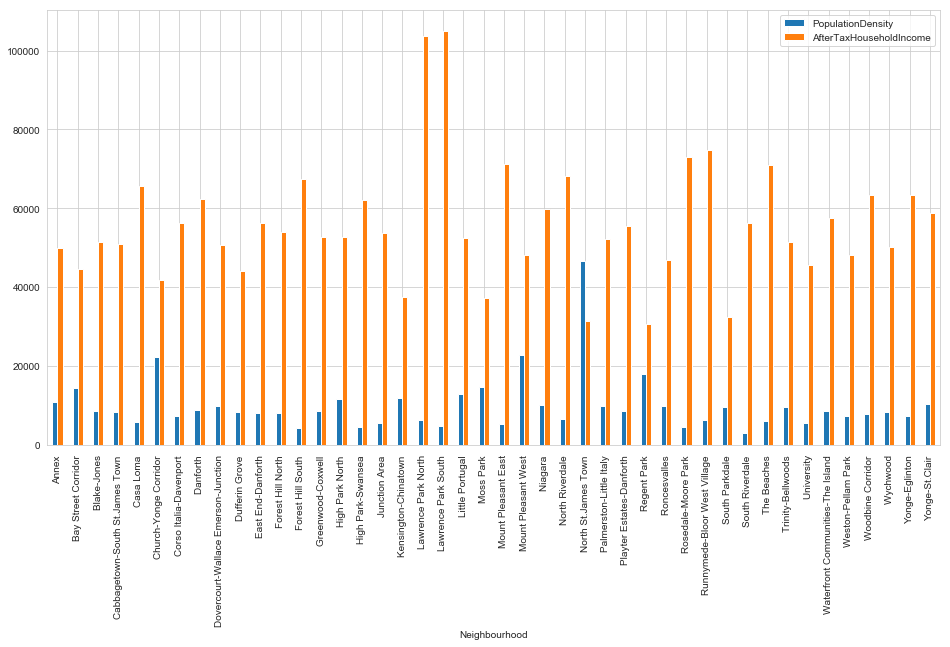

In [32]:
sns.set_style('whitegrid')
df_toronto_bar = pd.DataFrame(df_toronto_nbh[['Neighbourhood','PopulationDensity','AfterTaxHouseholdIncome']]).copy()
df_toronto_bar.set_index('Neighbourhood',inplace=True)
fig = df_toronto_bar.plot(kind='bar',figsize=(16,8)).get_figure()
fig.savefig('toronto_inc_bar.png')
plt.show()

**Note**: Also note that some of the neighbourhoods with a high average income have<br>
a lower population density, which could mean a spacious suburb with large housing plots

### Number of Venues by Neighbourhood
The graph below visualizes the number of venues by neighbourhood. Looking at two of the neighbourhoods<br>
with the highest incomes, Lawrence Park South & North, we notice that the number of venues is relatively<br>
small compared to the others. Forest Hill North & South are similar neighbourhoods.

**Note**: Due to the cap of 100 venues in the Foursquare API endpoint "explore", it is not possible<br>
to retrieve more. 

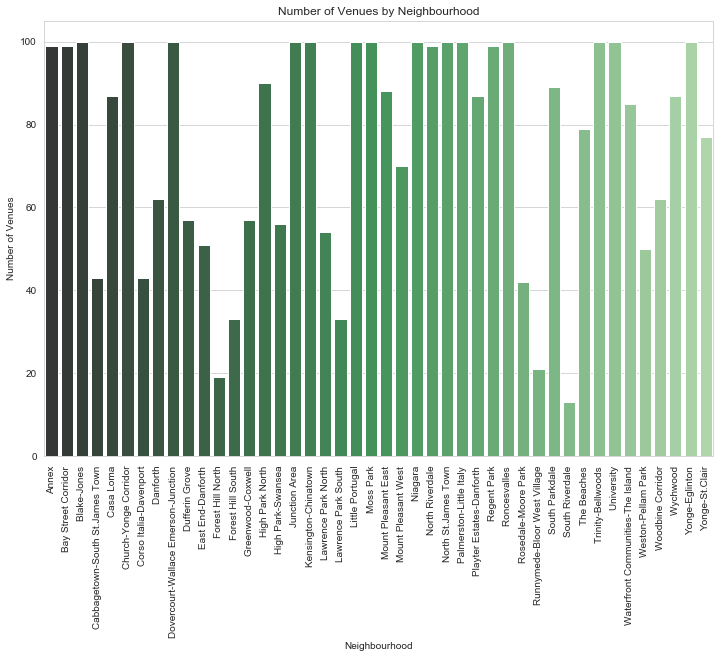

In [33]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
count_plt = sns.countplot(x="Neighbourhood", data=df_toronto_ven, palette='Greens_d') #,height=12, aspect=0.8)
count_plt.set_ylabel('Number of Venues')
count_plt.set_xticklabels(count_plt.get_xticklabels(), rotation=90)
count_plt.set_title("Number of Venues by Neighbourhood")
plt.show()
count_plt.figure.savefig('tornto_ven_by_nbh.png')

### Which machine learning algorithm to use?

The goal of for this project was to provide a (future) business owner with business location information<br>
for making a more informed decision. Looking a possible suitable machine learning algorithms, I have chosen to<br> focus on either a recommender system or using K-Means clustering for the solution. 

After long thought on which machine learning algorithm to use, I have decided to use the K-Means<br>
clustering algorithm to provide better insight. Along with the other exploratory data analysis, it should be<br>
possible to categorize the clusters as found by the K-Means clustering algorithm.

### The first step in preparing for the K-Means algorithm:

  * By using the pandas get_dummies method we are creating a dataframe with a column for each category.
  * Then used this dataframe to create a dataframe representing the percentage of venues for a category by neighbourhood

In [34]:
# get the venue category count by neighbourhood to add to the neighbourhoods dataframe
df_toronto_onehot = pd.get_dummies(df_toronto_ven[['Category']], prefix="", prefix_sep="")
# add neighbourhood column back to dataframe
df_toronto_onehot['Neighbourhood'] = df_toronto_ven['Neighbourhood'] 
# add neighbourhood column back to dataframe
df_toronto_onehot['Neighbourhood'] = df_toronto_ven['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [df_toronto_onehot.columns[-1]] + list(df_toronto_onehot.columns[:-1])
df_toronto_onehot = df_toronto_onehot[fixed_columns]
df_toronto_grp = df_toronto_onehot.groupby('Neighbourhood').mean().reset_index()

### Add the normalized (between 0 and 1) population denstity and avg. income by neighbourhood ...
  * Add the columns to the df_toronto_grp dataframe after normalizing 

In [35]:
# we need to reset the index before using the dataframe to normalize the attributes
df_toronto_bar.reset_index(inplace=True)
# add the population density and average household income as well and normalize between 0 and 1
# and add to the grouped venues catagory
x = df_toronto_bar[['PopulationDensity','AfterTaxHouseholdIncome']].values #returns a numpy array
# set the range between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# normalize
x_scaled = min_max_scaler.fit_transform(x) #.reshape(-1,1))
# add the columns to the grouped by category
df_toronto_grp[['PopulationDensity','AfterTaxHouseholdIncome']] = pd.DataFrame(x_scaled,columns=['PopulationDensity','AfterTaxHouseholdIncome'])
df_toronto_grp.head()

,Neighbourhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,PopulationDensity,AfterTaxHouseholdIncome
0,Annex,0.070707,0.000000,0.656566,0.040404,0.040404,0.030303,0.151515,0.010101,0.183297,0.257485
1,Bay Street Corridor,0.080808,0.010101,0.616162,0.030303,0.040404,0.010101,0.212121,0.000000,0.261906,0.186130
2,Blake-Jones,0.020000,0.000000,0.720000,0.090000,0.020000,0.000000,0.140000,0.010000,0.130220,0.277270
3,Cabbagetown-South St.James Town,0.046512,0.000000,0.581395,0.046512,0.209302,0.000000,0.116279,0.000000,0.124467,0.270428
4,Casa Loma,0.068966,0.000000,0.609195,0.011494,0.068966,0.011494,0.195402,0.034483,0.065751,0.468424


### Run the K-Means algorithm several times to determine the optimal number of clusters to use
  * Once run the model returns a value of inertia: model.inertia_.
  * We are looking for a number of clusters where the inertia visibly flattens out

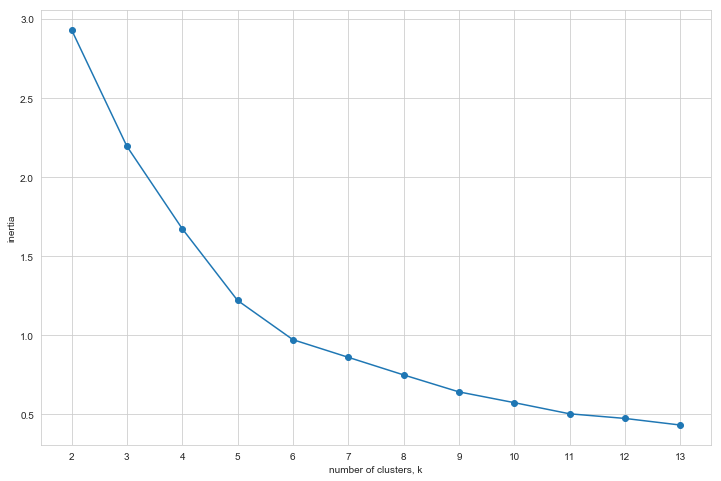

In [36]:
# now get the optimal K
ks = range(2, 14)
inertias = []
df_toronto_grp_clu_tmp = df_toronto_grp.drop('Neighbourhood', 1)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=0)
    
    # Fit model to samples
    model.fit(df_toronto_grp_clu_tmp)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
fig = plt.figure(figsize=(12,8))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
fig.savefig('kmeans_elbow_diagram.png')

**Note**: from the elbow graph shown above, the optimal number of clusters is around 7 as the intertia really begins to descrease

### We have determined the optimal number of clusters = 7.

Now run K-Means on the normalized columns of the venues grouped dataframe df_toronto_grp

In [37]:
# set number of clusters as determined in the elbow plot above
kclusters = 7
#df_toronto_grp_clu = df_toronto_grp.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_toronto_grp.drop(columns=['Neighbourhood']))
# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 6, 0, 0, 4, 6, 0, 4, 0, 0, 0, 2, 2, 0, 0, 5, 0, 6, 1, 1, 0, 6,
       4, 6, 2, 4, 3, 0, 0, 6, 0, 5, 4, 6, 5, 2, 0, 0, 0, 0, 2, 0, 4, 0],
      dtype=int32)

### Merge the venues grouped by category dataframe along with the neighbourhoods dataframe

  * Add the cluster labels column kmeans.labels_ to the dataframe
  * Merge the venues grouped by category dataframe with the neighbourhoods dataframe
  * Plot the merged dataframe using Choropleth to view the results of the K-Means clustering

In [38]:
df_toronto_grp.insert(loc=0, column='Cluster Labels', value=kmeans.labels_)
# now merge both to one dataframe
df_toronto_mrg = pd.merge(left=df_toronto_nbh,right=df_toronto_grp, on='Neighbourhood')
df_toronto_mrg.head()

,CDN_Number,Neighbourhood,geometry,Latitude,Longitude,TotalPopulation,TotalArea,AfterTaxHouseholdIncome_x,PopulationDensity_x,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,PopulationDensity_y,AfterTaxHouseholdIncome_y
0,095,Annex,"POLYGON ((-79.39414141500001 43.668720261, -79...",43.671585,-79.404000,30526,2.8,49912,10902.0,0,0.070707,0.000000,0.656566,0.040404,0.040404,0.030303,0.151515,0.010101,0.183297,0.257485
1,076,Bay Street Corridor,"POLYGON ((-79.38751633 43.650672917, -79.38662...",43.657512,-79.385722,25797,1.8,44614,14332.0,6,0.080808,0.010101,0.616162,0.030303,0.040404,0.010101,0.212121,0.000000,0.261906,0.186130
2,069,Blake-Jones,"POLYGON ((-79.34082169200001 43.669213123, -79...",43.676173,-79.337394,7727,0.9,51381,8586.0,0,0.020000,0.000000,0.720000,0.090000,0.020000,0.000000,0.140000,0.010000,0.130220,0.277270
3,071,Cabbagetown-South St.James Town,"POLYGON ((-79.376716938 43.662418858, -79.3772...",43.667648,-79.366107,11669,1.4,50873,8335.0,0,0.046512,0.000000,0.581395,0.046512,0.209302,0.000000,0.116279,0.000000,0.124467,0.270428
4,096,Casa Loma,"POLYGON ((-79.414693177 43.673910413, -79.4148...",43.681852,-79.408007,10968,1.9,65574,5773.0,4,0.068966,0.000000,0.609195,0.011494,0.068966,0.011494,0.195402,0.034483,0.065751,0.468424


## Analysis <a name="analysis"/>

### Visualize the K-Means clustering by neighbourhood on a map

  * Map the outlines of the neighbourhood boundaries
  * Plot the assigned cluster of each neighbourhood using a different color for each cluster
  * With this plot is should be easier to discover the patterns in the clustering assignment

In [41]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_toronto_clu = folium.Map(location=[43.673963, -79.387207], zoom_start=12)
# draw boundaries
map_toronto_clu.choropleth(geo_data=toronto_geojson,
      fill_opacity=0.1,
      line_opacity=0.5,
      legend_name='K-Means Clusters by Neighbourhood')   
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['#9400D3','#4B0082','#0000FF','#00FF00','#FFFF00','#FF7F00','#FF0000']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto_mrg['Latitude'], df_toronto_mrg['Longitude'], df_toronto_mrg['Neighbourhood'], df_toronto_mrg['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    toolt = str(poi) + ' Cluster ' + str(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        tooltip=toolt,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_toronto_clu) 
map_toronto_clu.save('toronto_map_clu.html')
#map_toronto_clu

<img src="toronto_map_clu2.jpeg"/>

**Legend**: (including initial analysis on the clustering results after looking at the map)
  1. Red = Cluster 0<br>- Most prominent, grouped around the downtown area
  2. Light Purple = Cluster 1<br>- Most northern neighbourhoods with a low population density and high avg. income
  3. Dark Purple = Cluster 2<br>- Appear to be located on outer neighbourhoods of the research area or close to a recreational area, needs further investigation
  4. Blue = Cluster 3<br>- Only one neighbourhood represented, needs some further investigation
  5. Green = Cluster 4<br>- Also appear to be located on outer neighbourhoods of the research area
  6. Yellow = Cluster 5<br>- Seems to be neighbourhoods with a larger park or recreational facilities
  7. Orange = Cluster 6<br>- Mainly grouped in the downtown area

### Analyze the clusters by looking at most prominent venue categories by neighbourhood
  * Create a cross table dataframe with number of venues by category by neighbourhood
  * We can use this to create a stacked bar plot showing the proportion of venues by category for each neighbourhood
  * This plot should also be helpful in detecting patterns behind the clustering assignment

In [42]:
# get the number of venues by category by neighbourhood
df_toronto_grp_cnt = df_toronto_ven.groupby(by=['Neighbourhood','Category']).size().unstack(fill_value=0)
df_toronto_grp_cnt.insert(loc=0, column='Cluster Labels', value=kmeans.labels_)
df_toronto_grp_cnt.sort_values(by=['Cluster Labels','Neighbourhood'],inplace=True)
df_toronto_grp_cnt.head()

Category,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Neighbourhood,,,,,,,,,
Annex,0,7,0,65,4,4,3,15,1
Blake-Jones,0,2,0,72,9,2,0,14,1
Cabbagetown-South St.James Town,0,2,0,25,2,9,0,5,0
Corso Italia-Davenport,0,0,0,30,1,3,0,6,3
Dovercourt-Wallace Emerson-Junction,0,3,0,54,18,4,0,20,1


### Plot the number of venues by category by neighbourhood

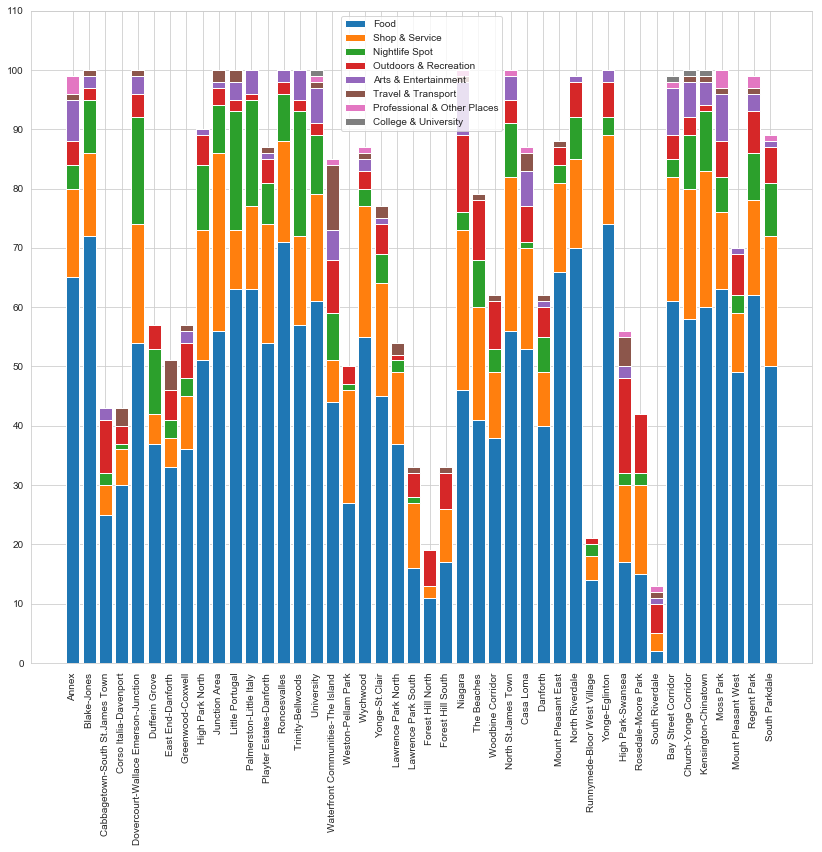

In [43]:
# plot the number of venues by category in a stacked bar plot by neighbourhood
wid_nbh = 0.5
cum_val = 0
# we want a list of column names (categories) sorted by the most venues in a category in descending order
col_nams = list(df_toronto_grp_cnt.sum().sort_values(ascending=False).index)
col_nams.remove('Cluster Labels')
fig = plt.figure(figsize=(14,12))
for col in col_nams:
    plt.bar(list(df_toronto_grp_cnt.index), df_toronto_grp_cnt[col], bottom=cum_val, label=col)
    cum_val = cum_val+df_toronto_grp_cnt[col]
_ = plt.xticks(rotation=90)
_ = plt.yticks(np.arange(0, 120, 10))
_ = plt.legend(fontsize=10)
plt.show()
fig.savefig('toronto_venues_by_nbh.png')

### Several observations here:
  **Neighbourhoods by cluster label number**:
  0. **From Annex to Wychwood**<br>
  Cluster 2 neighbourhoods are in the majority. They have a relatively large number of food related venues<br>
  And shops, services and nightlife venues are also prominent. The locations are located to the west/north-west<br>
  of the downtown area, as well as to the east
  1. **Lawrence Park North and South**<br>
  Both neighbourhoods have a high average income and low population density which would lead to<br>
  conclude that these are mainly residential areas
  2. **Forest Hill North to Woodbine Corridor**<br>
  There appears to be a relatively large number of shops and services in these neighbourhoods<br>
  And also relatively less nightlife spots (bars, clubs etc.) compared to the cluster 0 (red) neighbourhoods.<br>
  The outdoors and recreational venues are also prominent. 
  3. **North St.James Town**<br>
  This neighbourhood has been separately clustered due to the fact that there it has the highest population<br>
  density of all the researched negighbourhoods. It has a relatively high number of shops and service venues.
  4. **From Casa Loma to Yonge-Eglinton**
  The cluster 4 neighbourhoods are located in the north and eastern part of the research area with one exception<br>
  located in the far west. Mainly on the outskirts. There are a relatively large number of shops and services<br>
  as well as outdoor and recreational venues. Nightlife venues are also prominent.
  5. **High Park-Swansea to South Riverdale**<br>
  These neighbourhoods are located in recreational areas like parks or close to the waterfront and have a<br>
  high percentage of outdoor and recreational venues as well as travel and transportation venues<br>
  (hotels, transportation hubs: bus, metro or train stations)
  6. **From Bay Street Corridor to South Parkdale**<br>
  These are neighbourhoods in the downtown area of Toronto with a high number of venues in the food category<br>
  like restaurants. Shops and services are also prominent as well as venues in the nightlife spot category
  
  
  * In almost all neighbourhoods venues within the food category (restaurants, coffee shops etc.)<br>
  are the most prominent
  * Shops & Services are the second most prominent all-round (stores, shops, fitness studios etc.)
  * Nightlife Spots are the third most prominent all-round (bars, speakeasy's, clubs etc)
  

### Create a dataframe to visualize the venue categories by venue count by neighbourhood

In [44]:
# create a sorted list for each neighbourhood with the category with highest number of venues first
# loop at the neighbourhoods 
nbh_dict = dict()
for nbh,row in df_toronto_grp_cnt.iterrows():
    ven_arr = []
    for ven_cat in df_toronto_grp_cnt.columns:
        ven_cnt = row[ven_cat]
        ven_arr.append([ven_cat,ven_cnt])
    # sort the array by the number of venues by category
    ven_arr = sorted(ven_arr, key=lambda x: x[1], reverse=True)
    # flatten the array to one dimension
    flat_arr = [val for sublist in ven_arr for val in sublist]
    # create a dictionary entry for the current neighbourhood
    nbh_dict[row.name] = flat_arr
# switch the column names and index around
df_toronto_grp_cnt_srt = pd.DataFrame(nbh_dict).transpose()
# now we need to fix the column headers to readable text
indic = ['st', 'nd', 'rd']
# create columns according to number of venues by category
columns = []
cnt = 0
for i in np.arange(len(df_toronto_grp_cnt_srt.columns)):
    if i % 2 == 0:
        cnt = cnt + 1
        try:
            columns.append('{}{} Category'.format(cnt, indic[cnt-1]))
        except:
            columns.append('{}th Category'.format(cnt))
    else:
        try:
            columns.append('{}{} # Venues'.format(cnt, indic[cnt-1]))
        except:
            columns.append('{}th # Venues'.format(cnt))
df_toronto_grp_cnt_srt.columns = columns
# we need to move the index to a column 
df_toronto_grp_cnt_srt.reset_index(inplace=True)
df_toronto_grp_cnt_srt.rename(columns={'index':'Neighbourhood'},inplace=True)
df_toronto_grp_cnt_srt.head()

,Neighbourhood,1st Category,1st # Venues,2nd Category,2nd # Venues,3rd Category,3rd # Venues,4th Category,4th # Venues,5th Category,5th # Venues,6th Category,6th # Venues,7th Category,7th # Venues,8th Category,8th # Venues,9th Category,9th # Venues
0,Annex,Food,65,Shop & Service,15,Arts & Entertainment,7,Nightlife Spot,4,Outdoors & Recreation,4,Professional & Other Places,3,Travel & Transport,1,Cluster Labels,0,College & University,0
1,Blake-Jones,Food,72,Shop & Service,14,Nightlife Spot,9,Arts & Entertainment,2,Outdoors & Recreation,2,Travel & Transport,1,Cluster Labels,0,College & University,0,Professional & Other Places,0
2,Cabbagetown-South St.James Town,Food,25,Outdoors & Recreation,9,Shop & Service,5,Arts & Entertainment,2,Nightlife Spot,2,Cluster Labels,0,College & University,0,Professional & Other Places,0,Travel & Transport,0
3,Corso Italia-Davenport,Food,30,Shop & Service,6,Outdoors & Recreation,3,Travel & Transport,3,Nightlife Spot,1,Cluster Labels,0,Arts & Entertainment,0,College & University,0,Professional & Other Places,0
4,Dovercourt-Wallace Emerson-Junction,Food,54,Shop & Service,20,Nightlife Spot,18,Outdoors & Recreation,4,Arts & Entertainment,3,Travel & Transport,1,Cluster Labels,0,College & University,0,Professional & Other Places,0


#### We will use this dataframe to merge with the clusters by neighbourhoods dataframe to have one dataframe for analysis

In [45]:
# add the cluster number, population density and average income so we can do some analysis on the clusters
df_toronto_analize = pd.merge(left=df_toronto_mrg[['Neighbourhood','Cluster Labels','AfterTaxHouseholdIncome_x','PopulationDensity_x']],
                              right=df_toronto_grp_cnt_srt,
                              on='Neighbourhood')
df_toronto_analize.rename(columns={'Cluster Labels':'Cluster','AfterTaxHouseholdIncome_x':'AvgIncome','PopulationDensity_x':'PopDensity'},inplace=True)
# display neighbourhoods by cluster
df_toronto_analize.sort_values(by=['Cluster','Neighbourhood']).to_csv('df_toronto_analize.csv')
df_toronto_analize.sort_values(by=['Cluster','Neighbourhood'],inplace=True)
df_toronto_analize

,Neighbourhood,Cluster,AvgIncome,PopDensity,1st Category,1st # Venues,2nd Category,2nd # Venues,3rd Category,3rd # Venues,4th Category,4th # Venues,5th Category,5th # Venues,6th Category,6th # Venues,7th Category,7th # Venues,8th Category,8th # Venues,9th Category,9th # Venues
0,Annex,0,49912,10902.0,Food,65,Shop & Service,15,Arts & Entertainment,7,Nightlife Spot,4,Outdoors & Recreation,4,Professional & Other Places,3,Travel & Transport,1,Cluster Labels,0,College & University,0
2,Blake-Jones,0,51381,8586.0,Food,72,Shop & Service,14,Nightlife Spot,9,Arts & Entertainment,2,Outdoors & Recreation,2,Travel & Transport,1,Cluster Labels,0,College & University,0,Professional & Other Places,0
3,Cabbagetown-South St.James Town,0,50873,8335.0,Food,25,Outdoors & Recreation,9,Shop & Service,5,Arts & Entertainment,2,Nightlife Spot,2,Cluster Labels,0,College & University,0,Professional & Other Places,0,Travel & Transport,0
6,Corso Italia-Davenport,0,56345,7438.0,Food,30,Shop & Service,6,Outdoors & Recreation,3,Travel & Transport,3,Nightlife Spot,1,Cluster Labels,0,Arts & Entertainment,0,College & University,0,Professional & Other Places,0
8,Dovercourt-Wallace Emerson-Junction,0,50741,9899.0,Food,54,Shop & Service,20,Nightlife Spot,18,Outdoors & Recreation,4,Arts & Entertainment,3,Travel & Transport,1,Cluster Labels,0,College & University,0,Professional & Other Places,0
9,Dufferin Grove,0,44145,8418.0,Food,37,Nightlife Spot,11,Shop & Service,5,Outdoors & Recreation,4,Cluster Labels,0,Arts & Entertainment,0,College & University,0,Professional & Other Places,0,Travel & Transport,0
10,East End-Danforth,0,56179,8223.0,Food,33,Outdoors & Recreation,5,Shop & Service,5,Travel & Transport,5,Nightlife Spot,3,Cluster Labels,0,Arts & Entertainment,0,College & University,0,Professional & Other Places,0
13,Greenwood-Coxwell,0,52770,8481.0,Food,36,Shop & Service,9,Outdoors & Recreation,6,Nightlife Spot,3,Arts & Entertainment,2,Travel & Transport,1,Cluster Labels,0,College & University,0,Professional & Other Places,0
14,High Park North,0,52827,11664.0,Food,51,Shop & Service,22,Nightlife Spot,11,Outdoors & Recreation,5,Arts & Entertainment,1,Cluster Labels,0,College & University,0,Professional & Other Places,0,Travel & Transport,0
16,Junction Area,0,53804,5525.0,Food,56,Shop & Service,30,Nightlife Spot,8,Outdoors & Recreation,3,Travel & Transport,2,Arts & Entertainment,1,Cluster Labels,0,College & University,0,Professional & Other Places,0


### Look a the mean and medians of average income and population density

In [46]:
# look a the mean and medians of average income and population density
df_toronto_analize[['AvgIncome','PopDensity']].describe()

,AvgIncome,PopDensity
count,44.000000,44.000000
mean,55981.727273,9972.568182
std,15130.504763,7034.026401
min,30794.000000,2904.000000
25%,48171.000000,6336.750000
50%,53315.500000,8461.000000
75%,62678.250000,10153.500000
max,105043.000000,46538.000000


## Analysis of clusters and neighbourhoods dataframe
- **Cluster 0** neighbourhoods have an average household income around the median of 53,315 Canadian dollars.
- **Cluster 1** neighbourhoods are those with the highest average household income and a low population density.<br> This would indicate a rich residential area 
- **Cluster 2** neighbourhoods have a higher than average household income above the overal median of 53,315 Canadian dollars.<br> The population density is lower than the overall median populatin density.
- **Cluster 3** neighbourhood North St.James Town has a very high population density and much lower than median household income.
- **Cluster 4** neighbourhoods have a relatively high average income and lower than median population density<br> which leads me to believe that these are mainly residential areas
- **Cluster 5** neighbourhoods High Park-Swansea, Rosedale-Moore Park and South Riverdale have a higher than median average household income<br> and a much lower than median population density. This is due to the fact that these neighbourhood all contain larger parks or beach areas within their boundaries.
- **Cluster 6** neighbourhoods have a relatively low average household income compared to the overall median average income of 53,351 Canadian dollars. The population density is high. This is most likely due to the fact that these neighbourhoods are located in the downtown area where the real estate prices are high leading to more concentration by square kilometer. 
